## Creation of a Portfolio using Markowitz Portfolio Theory
###### Steps:
1. For a given time-period we first calculate the returns and volatility
2. We then plot an efficient frontier, which basically is the set of optimal portfolios that offer the highest expected return for a defined level of    risk.
3. We then find the tangency portfolio, which maximizes the Shapre ratio

In [1]:
import pandas as pd
import numpy as np

In [2]:
# We import a csv file that has all the industry returns from 1930-2009
ind = pd.read_csv("C:/Users/sandh/OneDrive/Documents/Data_files/data/ind30_m_ew_rets.csv",header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
ind.columns = ind.columns.str.strip()
ind.head()
cov = ind.cov()

##### To make the data more relevant we would only look at the data from 1996 onwards
###### First, we will calculate the annualized returns of these industry over the years

<AxesSubplot:>

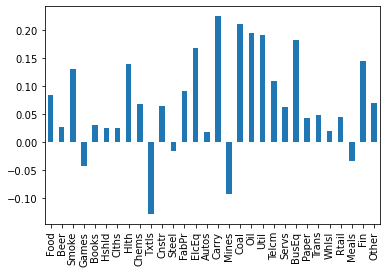

In [9]:
def annualize_rets(df):
    compounded_growth = (1+df).prod()
    n_periods = df.shape[0]
    return compounded_growth**(12/n_periods)-1
annualize_rets(ind["1996":"2000"]).plot.bar()

In [4]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In [11]:
er = annualize_rets(ind["1996":"2000"])
cov = ind["1996":"2000"].cov()

## Plotting the Efficient Frontier
#### Let's assign weights to the different industries that we might choose for our portfolio
In the case of 2 assets, the problem is somewhat simplified, since the weight of the second asset is 1-the weight of the first asset.
We will write a function that draws the efficient frontier for a simple 2 asset case.
We will start by generating a sequence of weights in a list of tuples.

In [12]:
import numpy as np

n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]


<AxesSubplot:xlabel='V', ylabel='R'>

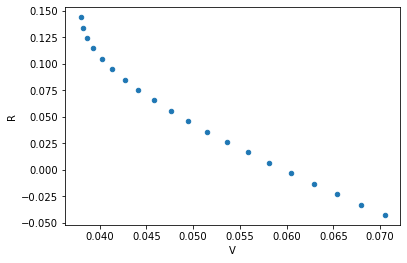

In [13]:
l = ["Games", "Fin"]
rets = [portfolio_return(w, er[l]) for w in weights]
vols = [portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({"R": rets, "V": vols})
ef.plot.scatter(x="V", y="R")

These are all the possible portfolios that we can choose from

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.

In [22]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [24]:
weights = minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = portfolio_vol(weights_15, cov.loc[l,l])
vol_15

NameError: name 'weights_15' is not defined